In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
my_secret = user_secrets.get_secret("WANDB_API_KEY") 

In [2]:
import wandb
wandb.login(key=my_secret)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yuvalmehta-728 (yuvalmehta-728-svkm-s-narsee-monjee-institute-of-managem). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm.auto import tqdm
from time import time
import warnings
from sklearn.impute import KNNImputer
warnings.filterwarnings("ignore")

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# Parameters

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 71 # for reproducibility
SATELLITE_EXTRA_LAYER = False # for adding layer to pre-built models
STREET_EXTRA_LAYER = False # for adding layer to pre-built models
BATCH_SIZE = 164 # number of samples processed in one training batch
EPOCHS = 15 # number of training iterations over the entire dataset
LEARNING_RATE = 1e-2 # to update model weights
IMG_SIZE = 224 # input image
NUM_FROZEN_LAYERS = 0 # 0 indicates that all layers are trainable
DROPOUT = 0.5
LABELS = ['AQI','PM2.5', 'PM10','O3', 'CO', 'SO2', 'NO2']

SATELLITE_ENCODER = 'resnet18'
STREET_ENCODER = 'resnet18'
RUN_NAME = 'st-resnet18_sv-resnet18_attn-gated'
TAGS = ['Street_resnet18', 'Satellite_resnet18', '7Bands', 'Extra Layer Off', 'GatedFusion (sigmoid)']

print(f"Using device: {device}")

Using device: cuda


In [6]:
wandb.init(
    project="AQI&MoleculeDetection",
    name=RUN_NAME,
    tags=TAGS,
    resume='allow',
    allow_val_change=True,
    config={
        "SEED": SEED,
        "SATELLITE_EXTRA_LAYER": SATELLITE_EXTRA_LAYER,
        "STREET_EXTRA_LAYER": STREET_EXTRA_LAYER,
        "BATCH_SIZE": BATCH_SIZE,
        "EPOCHS": EPOCHS,
        "LEARNING_RATE": LEARNING_RATE,
        "IMG_SIZE": IMG_SIZE,
        "NUM_FROZEN_LAYERS": NUM_FROZEN_LAYERS,
        "DROPOUT": DROPOUT,
        "DEVICE": str(device),
        "SATELLITE_ENCODER": SATELLITE_ENCODER,
        "STREET_ENCODER": STREET_ENCODER,
        "LABELS": LABELS
    }
)


# Dataset
- Loads dataset: https://www.kaggle.com/datasets/adarshrouniyar/air-pollution-image-dataset-from-india-and-nepal
- CSV consists of places and AQI measures
- We have added an additional field for sattelite image path which was collected separately using Google earth engine.
- Fields: Location, Filename (the street view image), Normalized_Filename (satellite image), Year, Month, Day, Hour, AQI, PM2.5, PM10, O3, CO, SO2, NO2, and AQI_Class

In [7]:
dataset_path = '/kaggle/input/aqi-dataset/dataset'
# dataset_path = './dataset'
train_csv = pd.read_csv(os.path.join(dataset_path, 'train_data.csv'))
val_csv = pd.read_csv(os.path.join(dataset_path, 'val_data.csv'))
test_csv = pd.read_csv(os.path.join(dataset_path, 'test_data.csv'))

# train_csv.interpolate(method='linear', inplace=True)
# val_csv.interpolate(method='linear', inplace=True)
# test_csv.interpolate(method='linear', inplace=True)

In [8]:
combined_df = pd.concat([train_csv, val_csv, test_csv])

# Perform interpolation and KNN imputation
# combined_df.interpolate(method='linear', inplace=True)
knn_imputer = KNNImputer(n_neighbors=5)
combined_df[['SO2', 'NO2', 'O3', 'CO']] = knn_imputer.fit_transform(combined_df[['SO2', 'NO2', 'O3', 'CO']])

# Split them back into separate datasets
train_csv = combined_df.iloc[:len(train_csv)]
val_csv = combined_df.iloc[len(train_csv):len(train_csv) + len(val_csv)]
test_csv = combined_df.iloc[len(train_csv) + len(val_csv):]

# Custom Dataset

#### **1. Initialization (`__init__`)**  
   - Takes a **CSV file** (*pandas DataFrame*) containing **filenames and labels**.  
   - **`satellite_img_dir`** & **`street_img_dir`**: Directories where **satellite** and **street images** are stored.  
   - **`label`**: Column name in the CSV corresponding to the **target label**.  
   - **`satellite_transform`** & **`street_transform`**: Optional transformations (e.g., **resizing, normalization**) for images.  

#### **2. Dataset Length (`__len__`)**  
   - Returns the **total number of samples** (rows) in the CSV file.  

#### **3. Get Item (`__getitem__`)**  
   - Retrieves the **street image** and **satellite image** paths from the CSV.  
   - Loads the images using the **`load_image()`** method.  
   - Applies the **respective transformations** if provided.  
   - Converts the **label** to a **PyTorch tensor** of type `float32`.  
   - Returns a tuple: **`(street_image, satellite_image, label)`**.  

#### **4. Image Loading (`load_image`)**  
   - Opens an image using **PIL** (`Image.open(file_path)`).  
   - Applies **transformations** if specified.  
   - Returns the **processed image**. 🚀  

In [9]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, satellite_img_dir, street_img_dir, label, satellite_transform=None, street_transform=None):
        self.data = csv_file
        self.street_img_dir = street_img_dir
        self.satellite_img_dir = satellite_img_dir
        self.label = label
        self.satellite_transform = satellite_transform
        self.street_transform = street_transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        street_image_path = os.path.join(self.street_img_dir, self.data['Filename'].iloc[idx])
        satellite_image_path = os.path.join(self.satellite_img_dir, self.data['Normalized_Filename'].iloc[idx]+'.npy' )
        
        street_image = self.load_image(street_image_path, self.street_transform)
        # satellite_image = self.load_image(satellite_image_path, self.satellite_transform)
        satellite_image = self.load_npy(satellite_image_path, self.satellite_transform)
        labels = torch.tensor(self.data[self.label].iloc[idx], dtype=torch.float32)
        
        return street_image, satellite_image, labels
        
    
    def load_image(self, file_path, transform=None):
        img = Image.open(file_path)
        if transform:
            img = transform(img)
        return img
    
    def load_npy(self, file_path, transform=None):
        img = np.load(file_path)
        img = torch.tensor(img, dtype=torch.float32)

        # If the data is in [0, 255], scale it to [0, 1]
        if img.max() > 1.0:  
            img = img / 255.0  

        # Ensure shape (C, H, W) if it's (H, W, C)
        if img.ndimension() == 3 and img.shape[-1] == 7:  
            img = img.permute(2, 0, 1)  
        if transform:
            img = transform(img)
        return img
    

## Data normalization and tranformation

In [10]:
image_net_means = [0.485, 0.456, 0.406] 
image_net_stds = [0.229, 0.224, 0.225]

satellite_net_means = [0.18168019890450375, 0.18805927958530722, 0.20592676343591497, 0.20806291225568016, 0.3423790143310607, 0.23654847637549638, 0.17482840221654344]

satellite_net_stds = [0.19048610465575523, 0.19615030016268702, 0.2125846014779801,  0.21476670175116374, 0.347457205638518, 0.2390436189214837, 0.17736793155031446]
# for data transformation
data_transforms = {
    'street_dev': transforms.Compose([
        transforms.ToTensor(),  # Converts (H, W, C) to (C, H, W)
        transforms.Normalize(tuple(image_net_means), tuple(image_net_stds))
    ]),
    'street_test': transforms.Compose([
        transforms.ToTensor(),  # Converts (H, W, C) to (C, H, W)
        transforms.Normalize(tuple(image_net_means), tuple(image_net_stds))
    ]),
    'satellite_dev': transforms.Compose([
        # transforms.ToTensor(),  # Converts (H, W, C) to (C, H, W)
        transforms.Resize((224, 224)),
        transforms.Normalize(tuple(satellite_net_means), tuple(satellite_net_stds))
    ]),
    'satellite_test': transforms.Compose([
        # transforms.ToTensor(),  # Converts (H, W, C) to (C, H, W)
        transforms.Resize((224, 224)),
        transforms.Normalize(tuple(satellite_net_means), tuple(satellite_net_stds))
    ])
}   
    
# image specific tranformations    
satellite_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  
    transforms.RandomVerticalFlip(),
    transforms.Normalize(tuple(satellite_net_means), tuple(satellite_net_stds)),
])

street_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(), 
    transforms.Normalize(tuple(image_net_means), tuple(image_net_stds)),
])

## Dataloaders 

1. **Creating Datasets (`CustomDataset`)**  
   - `train_dataset`: Uses **augmented transforms** (`satellite_transform`, `street_transform`).  
   - `val_dataset` & `test_dataset`: Use **only normalization** (`data_transforms['dev']` & `data_transforms['test']`).  

2. **Data Loaders (`DataLoader`)**  
   - `train_loader`: Loads training data with **shuffling** for randomness.  
   - `val_loader` & `test_loader`: Load validation & test data **without shuffling** for consistency.  

Usage:
- Prepares **train, validation, and test sets** for deep learning models.  
- Uses **batch processing (`batch_size=BATCH_SIZE`)** for efficient training.  
- **`next(iter(train_loader))`** retrieves a single batch to inspect data. 🚀

In [11]:
train_dataset = CustomDataset(train_csv, os.path.join(dataset_path, 'satellite_images'), os.path.join(dataset_path, 'All_img'), LABELS, satellite_transform, street_transform)

val_dataset = CustomDataset(val_csv, os.path.join(dataset_path, 'satellite_images'), os.path.join(dataset_path, 'All_img'), LABELS, data_transforms['satellite_dev'], data_transforms['street_dev'])

test_dataset = CustomDataset(test_csv, os.path.join(dataset_path, 'satellite_images'), os.path.join(dataset_path, 'All_img'), LABELS, data_transforms['satellite_test'], data_transforms['street_test'])

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# data = next(iter(train_loader))

In [13]:
len(train_loader), len(val_loader), len(test_loader)


(48, 12, 15)

In [14]:
# temp = next(iter(train_loader))
# print(temp[0].shape, temp[1].shape, temp[2].shape)

# Loss Functions

In [15]:
def loss_fn_regression(outputs, targets):
    """
    Loss function for regression
    """
    return nn.MSELoss()(outputs, targets)


def loss_fn_classification(outputs, targets):
    """
    Loss function for classification
    """

    return nn.CrossEntropyLoss()(outputs, targets)


def accuracy(outputs, targets):
    """
    Accuracy function
    """

    return (outputs.argmax(1) == targets).float().mean()


def rmse(outputs, targets):
    """
    RMSE function
    """

    return torch.sqrt(nn.MSELoss()(outputs, targets))


def mae(outputs, targets):
    """
    MAE function
    """

    return nn.L1Loss()(outputs, targets)

def multi_task_loss(aqi_pred, aqi_true, pm_pred, pm_true, gas_pred, gas_true, loss_fn=loss_fn_regression, weights=None):
    
    if weights is None:
        weights = [1.0, 1.0, 1.0]  # Default equal weights for AQI, PM, and Gases

    # print(weights)
    loss_aqi = loss_fn(aqi_pred, aqi_true)
    loss_pm = loss_fn(pm_pred, pm_true)
    loss_gas = loss_fn(gas_pred, gas_true)
    # print(loss_aqi, loss_pm, loss_gas)
    # Weighted sum of losses
    total_loss = weights[0] * loss_aqi + weights[1] * loss_pm + weights[2] * loss_gas
    return total_loss

def dynamic_task_weights(y_aqi, y_pm, y_gas):
    # Compute inverse variance (higher variance → lower weight)
    var_aqi = torch.var(y_aqi)
    var_pm = torch.var(y_pm)
    var_gas = torch.var(y_gas)

    weights = 1 / (torch.tensor([var_aqi, var_pm, var_gas]) + 1e-6)  # Avoid division by zero
    weights /= torch.sum(weights)  # Normalize weights to sum to 1
    return weights.tolist()

# Batch processing - forward pass
Processes a batch of data through the model and computes loss & metrics.  

1. **Inputs:**  
   - `data`: (street images, satellite images, targets)  
   - `model`: Deep learning model  
   - `device`: CPU/GPU  
   - `is_classification`: Flag for classification vs. regression  

2. **Steps:**  
   - Move data to **device**.  
   - Forward pass through **model**.  
   - Compute **loss** (classification or regression).  
   - Compute **accuracy** (only for classification).  
   - Compute **RMSE & MAE** (for both tasks).  

3. **Outputs:**  
   - Loss, Accuracy (0 for regression), RMSE, MAE 🚀

In [16]:
def process_batch(data, model, device, is_classification):
    """Processes a batch and returns outputs, loss, and metrics."""
    street_img, satellite_img, targets = data
    street_img, satellite_img, targets = street_img.to(device), satellite_img.to(device), targets.to(device)
    
    outputs = model(street_img, satellite_img)
    
    if is_classification:
        loss = loss_fn_classification(outputs, targets)
        acc = accuracy(outputs, targets).item()
        rmse_score = 0
        mae_score = 0
    else:
        aqi_pred, pm_pred, gas_pred = outputs
        
        target_aqi = targets[:, 0].unsqueeze(1)  # AQI (1 value)
        target_pm = targets[:, 1:3]  # PM2.5, PM10 (2 values)
        target_gas = targets[:, 3:]  # O3, CO, SO2, NO2 (4 values)

        weights = dynamic_task_weights(target_aqi, target_pm, target_gas)
        # print(weights)
        
        loss = multi_task_loss(aqi_pred, target_aqi, pm_pred, target_pm, gas_pred, target_gas, weights=weights)
        acc = 0  # Not applicable for regression

        rmse_score = multi_task_loss(aqi_pred, target_aqi, pm_pred, target_pm, gas_pred, target_gas, rmse, weights=weights).item()
        mae_score = multi_task_loss(aqi_pred, target_aqi, pm_pred, target_pm, gas_pred, target_gas, mae, weights=weights).item()

    return loss, acc, rmse_score, mae_score
    

# Train and evaluation functions
1. **`train_fn(model, optimizer, scheduler, data_loader, device, is_classification=False)`**  
   - Trains the model for one epoch by iterating over the training dataset, computing loss, and updating weights using backpropagation.  
   - Tracks and prints batch-wise loss, RMSE, and MAE while applying learning rate scheduling.  

2. **`eval_fn(model, data_loader, device, is_classification=False)`**  
   - Evaluates the model on validation or test data without updating weights.  
   - Computes and returns the average loss, accuracy (if applicable), RMSE, and MAE for the entire dataset.  

3. **`train(model, optimizer, scheduler, train_loader, val_loader, test_loader, device, epochs=10, best_model_path='best_model.pth')`**  
   - Manages the full training process across multiple epochs, tracking performance on both training and validation sets.  
   - Saves the best-performing model based on validation loss and evaluates it on the test dataset after training. 🚀

In [17]:
def train_fn(model, optimizer, scheduler, data_loader, device, is_classification=False):
    """Training function"""
    model.train()
    total_loss, total_acc, total_rmse, total_mae = 0, 0, 0, 0

    for i, data in tqdm(enumerate(data_loader), total=len(data_loader), desc="Training"):
        optimizer.zero_grad()

        loss, acc, rmse_score, mae_score = process_batch(data, model, device, is_classification)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Aggregate metrics
        total_loss += loss.item()
        total_acc += acc
        total_rmse += rmse_score
        total_mae += mae_score
        
        wandb.log({
            "batch_loss": loss.item(),
            "batch_acc": acc,
            "batch_rmse": rmse_score,
            "batch_mae": mae_score
        })

        print(f"Batch: {i+1}/{len(data_loader)}, Loss: {total_loss / (i+1):.4f}, RMSE: {total_rmse / (i+1):.4f}, MAE: {total_mae / (i+1):.4f}", end='\r')

    print()  # Ensure proper formatting after tqdm

    epoch_loss = total_loss / len(data_loader)
    epoch_acc = total_acc / len(data_loader)
    epoch_rmse = total_rmse / len(data_loader)
    epoch_mae = total_mae / len(data_loader)

    # Log epoch-wise metrics to WandB
    wandb.log({
        "epoch_loss": epoch_loss,
        "epoch_acc": epoch_acc,
        "epoch_rmse": epoch_rmse,
        "epoch_mae": epoch_mae
    })

    return epoch_loss, epoch_acc, epoch_rmse, epoch_mae

In [18]:
def eval_fn(model, data_loader, device, is_classification=False):
    """Evaluation function"""
    model.eval()
    total_loss, total_acc, total_rmse, total_mae = 0, 0, 0, 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(data_loader), total=len(data_loader), desc="Evaluating"):
            loss, acc, rmse_score, mae_score = process_batch(data, model, device, is_classification)

            total_loss += loss.item()
            total_acc += acc
            total_rmse += rmse_score
            total_mae += mae_score

    val_loss = total_loss / len(data_loader)
    val_acc = total_acc / len(data_loader)
    val_rmse = total_rmse / len(data_loader)
    val_mae = total_mae / len(data_loader)

    # Log validation metrics to WandB
    wandb.log({
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_rmse": val_rmse,
        "val_mae": val_mae
    })

    return val_loss, val_acc, val_rmse, val_mae

In [19]:
def train(model, optimizer, scheduler, train_loader, val_loader, test_loader, device, epochs=10, best_model_path='best_model.pth'):
    """Main training loop"""
    model.to(device)
    history = {"losses": [], "accuracies": [], "rmse_scores": [], "mae_scores": []}

    best_loss = np.inf
    # best_model_path = "best_model.pth"

    for epoch in tqdm(range(epochs), desc="Epochs"):
        train_metrics = train_fn(model, optimizer, scheduler, train_loader, device, is_classification=False)
        val_metrics = eval_fn(model, val_loader, device, is_classification=False)

        history["losses"].append((train_metrics[0], val_metrics[0]))
        history["accuracies"].append((train_metrics[1], val_metrics[1]))
        history["rmse_scores"].append((train_metrics[2], val_metrics[2]))
        history["mae_scores"].append((train_metrics[3], val_metrics[3]))

        print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_metrics[0]:.4f}, Train Acc: {train_metrics[1]:.4f}, Train RMSE: {train_metrics[2]:.4f}, Train MAE: {train_metrics[3]:.4f}, Val Loss: {val_metrics[0]:.4f}, Val Acc: {val_metrics[1]:.4f}, Val RMSE: {val_metrics[2]:.4f}, Val MAE: {val_metrics[3]:.4f}")

        # Save best model
        if val_metrics[0] < best_loss:
            best_loss = val_metrics[0]
            torch.save(model.state_dict(), best_model_path)
            wandb.save(best_model_path) 

    # Load best model and evaluate on test set
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    test_metrics = eval_fn(model, test_loader, device, is_classification=False)
    wandb.log({
        "test_loss": test_metrics[0],
        "test_acc": test_metrics[1],
        "test_rmse": test_metrics[2],
        "test_mae": test_metrics[3]
    })
    print(f"Test Loss: {test_metrics[0]:.4f}, Test Acc: {test_metrics[1]:.4f}, Test RMSE: {test_metrics[2]:.4f}, Test MAE: {test_metrics[3]:.4f}")

    return history

# Plotting metrics

In [20]:
def plot_metrics(losses, accuracies, rmse_scores, mae_scores, model_name="Model Metrics"):
    """
    Plot training metrics with a title.
    """

    fig, ax = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle(model_name, fontsize=20, fontweight="bold")  # Add model title

    ax[0, 0].plot(losses)
    ax[0, 0].set_title("Loss")
    ax[0, 0].legend(["Train", "Val"])

    ax[0, 1].plot(accuracies)
    ax[0, 1].set_title("Accuracy")
    ax[0, 1].legend(["Train", "Val"])

    ax[1, 0].plot(rmse_scores)
    ax[1, 0].set_title("RMSE")
    ax[1, 0].legend(["Train", "Val"])

    ax[1, 1].plot(mae_scores)
    ax[1, 1].set_title("MAE")
    ax[1, 1].legend(["Train", "Val"])

    plt.show()


# Base Model
1. Initializes base based on architecture selected.
2. Removes classification layer
3. Adjusts first layer based on number of channels
4. Adds final layers to extract features of image
5. Freeze layers depending on number of layers
6. Combine everything

In [21]:
class BaseEncoder(nn.Module):
    """
    A flexible encoder model that supports different architectures (ResNet, EfficientNet, etc.).
    """

    def __init__(self, arch="resnet18", pretrained=True, no_channels=3, dropout=0.5, add_block=False, num_frozen=0):
        super(BaseEncoder, self).__init__()

        self.add_block = add_block
        self.num_frozen = num_frozen

        # Dictionary of available architectures
        arch_dict = {
            "resnet18": models.resnet18,
            "resnet50": models.resnet50,
            "resnet101": models.resnet101,
            "efficientnet_b0": models.efficientnet_b0,
            "efficientnet_b4": models.efficientnet_b4,
        }

        assert arch in arch_dict, f"Unsupported architecture: {arch}. Choose from {list(arch_dict.keys())}"

        # Load the model
        self.model = arch_dict[arch](weights="DEFAULT" if pretrained else None)

        if "resnet" in arch:
            self.feature_dim = self.model.fc.in_features
            self.model.fc = nn.Identity()  
        elif "efficientnet" in arch:
            self.feature_dim = self.model.classifier[1].in_features
            self.model.classifier = nn.Identity() 

        if no_channels != 3:
            if "resnet" in arch:
                self.model.conv1 = nn.Conv2d(no_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            elif "efficientnet" in arch:
                self.model.features[0][0] = nn.Conv2d(no_channels, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


        if self.add_block:
            self.addition_block = nn.Sequential(
                nn.Linear(self.feature_dim, self.feature_dim),
                nn.BatchNorm1d(self.feature_dim),
                nn.Dropout(dropout),
                nn.Linear(self.feature_dim, self.feature_dim)
            )

        self.final_layers = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout),
            nn.Linear(512, 512)
        )

        self.freeze_layers()

    def freeze_layers(self):
        """
        Freeze the first `num_frozen` layers of the model.
        """
        layers = list(self.model.children())
        assert 0 <= self.num_frozen <= len(layers), \
            f"num_frozen should be between 0 and {len(layers)}"

        for i, child in enumerate(layers):
            if i < self.num_frozen:
                for param in child.parameters():
                    param.requires_grad = False

        print(f"Number of frozen layers: {self.num_frozen}")

    def forward(self, x):
        x = self.model(x)
        if self.add_block:
            x = self.addition_block(x)
        # x = self.final_layers(x)
        return x


In [22]:
class GatedFusion(nn.Module):
    def __init__(self, in_dim1, in_dim2):
        super(GatedFusion, self).__init__()
        self.attn1 = nn.Linear(in_dim1, 1) 
        self.attn2 = nn.Linear(in_dim2, 1)

    def forward(self, x1, x2):
        weight1 = torch.sigmoid(self.attn1(x1)) 
        weight2 = torch.sigmoid(self.attn2(x2)) 

        # Normalize weights so they sum to 1
        # total_weight = weight1 + weight2 + 1e-6  
        # weight1 /= total_weight
        # weight2 /= total_weight

        fused = torch.cat((weight1 * x1, weight2 * x2), dim=1)  
        return fused


# AQI model
1. Concats output from 2 models: 1 for satellite features, 1 for street image features
2. Adds final layers (depending on classification, regression)
3. Forming a single model

In [23]:
class AQIPrediction(nn.Module):
    """
    Unified model
    """
    
    def __init__(self, satellite_model, street_model, dropout=0.5, num_classes=None):
        
        super(AQIPrediction, self).__init__()
        
        self.satellite_model = satellite_model
        self.street_model = street_model
        self.num_classes = num_classes
        
        self.feature_dim = satellite_model.feature_dim + street_model.feature_dim
        
        self.attention = GatedFusion(satellite_model.feature_dim, street_model.feature_dim)
        
        self.final_layers = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        if num_classes:
            self.final_layers[-1] = nn.Linear(128, num_classes)
        else:
            self.aqi_head = nn.Sequential(nn.Linear(128, 1), nn.ReLU())  
            self.pm_head = nn.Sequential(nn.Linear(128, 2), nn.ReLU())   # PM2.5 & PM10
            self.gas_head = nn.Sequential(nn.Linear(128, 4), nn.ReLU())  # O3, CO, SO2, NO2
  
            
            
    def forward(self, street_img, satellite_img):
        
        street_features = self.street_model(street_img)
        satellite_features = self.satellite_model(satellite_img)
        
        # features = torch.cat((street_features, satellite_features), dim=1)
        features = self.attention(street_features, satellite_features)
        
        output = self.final_layers(features)
        if self.num_classes:
            return output
            
        return self.aqi_head(output), self.pm_head(output), self.gas_head(output)
        

# Putting it all together
Creating the training pipeline

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 213MB/s]


Number of frozen layers: 0
Number of frozen layers: 0


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/48 [00:00<?, ?it/s]

[0.254908949136734, 0.1681698113679886, 0.576921284198761]
[0.29094070196151733, 0.1891276240348816, 0.5199316740036011]
[0.30677199363708496, 0.20358072221279144, 0.4896473288536072]
[0.29821479320526123, 0.22810517251491547, 0.4736800491809845]
[0.2505781352519989, 0.19657066464424133, 0.5528512001037598]
[0.2389761060476303, 0.22290478646755219, 0.5381191372871399]
[0.24765753746032715, 0.1896650642156601, 0.5626773238182068]
[0.20727072656154633, 0.1689830720424652, 0.6237462162971497]
[0.24024620652198792, 0.1719764769077301, 0.5877773761749268]
[0.25716331601142883, 0.22093911468982697, 0.5218976140022278]
[0.2656533718109131, 0.22342854738235474, 0.5109180808067322]
[0.25867369771003723, 0.242098867893219, 0.499227374792099]1
[0.23446983098983765, 0.2087491750717163, 0.556780993938446]
[0.26531553268432617, 0.1882806271314621, 0.5464038848876953]
[0.2970087230205536, 0.1862228363752365, 0.5167683959007263]
[0.26837217807769775, 0.2195059210062027, 0.512121856212616]
[0.248144239

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

[0.25666528940200806, 0.20036359131336212, 0.542971134185791]
[0.2788989543914795, 0.17095153033733368, 0.5501495003700256]
[0.2551088035106659, 0.1760597825050354, 0.5688314437866211]
[0.2722471058368683, 0.21402494609355927, 0.5137279033660889]
[0.26348352432250977, 0.21152982115745544, 0.5249866247177124]
[0.2601132094860077, 0.2011691927909851, 0.5387176275253296]
[0.26174259185791016, 0.19471342861652374, 0.5435439944267273]
[0.25593218207359314, 0.20910383760929108, 0.5349639654159546]
[0.2461710125207901, 0.15995922684669495, 0.5938697457313538]
[0.23540878295898438, 0.17277051508426666, 0.5918206572532654]
[0.24967718124389648, 0.1722634732723236, 0.5780593156814575]
[0.2367435097694397, 0.17579498887062073, 0.5874614715576172]
Epoch: 1/3, Train Loss: 19499.0128, Train Acc: 0.0000, Train RMSE: 129.5418, Train MAE: 93.5230, Val Loss: 111895.8685, Val Acc: 0.0000, Val RMSE: 332.0433, Val MAE: 175.8362


Training:   0%|          | 0/48 [00:00<?, ?it/s]

[0.2773714065551758, 0.2034258097410202, 0.5192027688026428]
[0.2679465413093567, 0.21477006375789642, 0.5172833800315857]
[0.2635425925254822, 0.19372019171714783, 0.5427371859550476]
[0.24615256488323212, 0.21855394542217255, 0.535293459892273]
[0.2448442280292511, 0.20694497227668762, 0.5482107996940613]
[0.26324546337127686, 0.1820344775915146, 0.5547200441360474]
[0.25260213017463684, 0.1978408396244049, 0.5495570302009583]
[0.2962605357170105, 0.221883624792099, 0.4818558096885681]
[0.3134802579879761, 0.19054581224918365, 0.49597394466400146]
[0.22308136522769928, 0.18760453164577484, 0.5893141627311707]
[0.23866833746433258, 0.22471879422664642, 0.5366129279136658]
[0.27673450112342834, 0.18194378912448883, 0.5413216948509216]
[0.20075945556163788, 0.15417811274528503, 0.6450624465942383]
[0.30987200140953064, 0.19218243658542633, 0.4979455769062042]
[0.2565276324748993, 0.18088744580745697, 0.5625849366188049]
[0.2576929032802582, 0.19701635837554932, 0.5452907681465149]
[0.24

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

[0.25666528940200806, 0.20036359131336212, 0.542971134185791]
[0.2788989543914795, 0.17095153033733368, 0.5501495003700256]
[0.2551088035106659, 0.1760597825050354, 0.5688314437866211]
[0.2722471058368683, 0.21402494609355927, 0.5137279033660889]
[0.26348352432250977, 0.21152982115745544, 0.5249866247177124]
[0.2601132094860077, 0.2011691927909851, 0.5387176275253296]
[0.26174259185791016, 0.19471342861652374, 0.5435439944267273]
[0.25593218207359314, 0.20910383760929108, 0.5349639654159546]
[0.2461710125207901, 0.15995922684669495, 0.5938697457313538]
[0.23540878295898438, 0.17277051508426666, 0.5918206572532654]
[0.24967718124389648, 0.1722634732723236, 0.5780593156814575]
[0.2367435097694397, 0.17579498887062073, 0.5874614715576172]
Epoch: 2/3, Train Loss: 9167.6884, Train Acc: 0.0000, Train RMSE: 90.5924, Train MAE: 61.2157, Val Loss: 5516.9384, Val Acc: 0.0000, Val RMSE: 72.7070, Val MAE: 51.4713


Training:   0%|          | 0/48 [00:00<?, ?it/s]

[0.2582712173461914, 0.2071910947561264, 0.534537672996521]
[0.24890460073947906, 0.22790834307670593, 0.5231870412826538]
[0.2705838978290558, 0.2295057326555252, 0.4999103248119354]
[0.3004431128501892, 0.20251113176345825, 0.4970458149909973]
[0.2573496997356415, 0.1660604327917099, 0.576589822769165]
[0.27981898188591003, 0.19286972284317017, 0.527311384677887]
[0.27797558903694153, 0.2353278249502182, 0.4866965115070343]
[0.24660558998584747, 0.19439691305160522, 0.5589975118637085]
[0.25820833444595337, 0.20158874988555908, 0.5402029752731323]
[0.23231911659240723, 0.19923286139965057, 0.5684480667114258]
[0.28506842255592346, 0.21132445335388184, 0.5036070942878723]
[0.2386406660079956, 0.16511791944503784, 0.5962414145469666]
[0.21713845431804657, 0.18365280330181122, 0.5992087125778198]
[0.21951892971992493, 0.17403453588485718, 0.6064465045928955]
[0.26877400279045105, 0.18516948819160461, 0.5460564494132996]
[0.2629373371601105, 0.18669341504573822, 0.5503692030906677]
[0.28

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

[0.25666528940200806, 0.20036359131336212, 0.542971134185791]
[0.2788989543914795, 0.17095153033733368, 0.5501495003700256]
[0.2551088035106659, 0.1760597825050354, 0.5688314437866211]
[0.2722471058368683, 0.21402494609355927, 0.5137279033660889]
[0.26348352432250977, 0.21152982115745544, 0.5249866247177124]
[0.2601132094860077, 0.2011691927909851, 0.5387176275253296]
[0.26174259185791016, 0.19471342861652374, 0.5435439944267273]
[0.25593218207359314, 0.20910383760929108, 0.5349639654159546]
[0.2461710125207901, 0.15995922684669495, 0.5938697457313538]
[0.23540878295898438, 0.17277051508426666, 0.5918206572532654]
[0.24967718124389648, 0.1722634732723236, 0.5780593156814575]
[0.2367435097694397, 0.17579498887062073, 0.5874614715576172]
Epoch: 3/3, Train Loss: 4776.9967, Train Acc: 0.0000, Train RMSE: 68.3857, Train MAE: 46.2577, Val Loss: 4227.5534, Val Acc: 0.0000, Val RMSE: 64.5007, Val MAE: 43.1130


Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

[0.9716419577598572, 0.020493069663643837, 0.007864976301789284]
[0.2476073056459427, 0.4323772192001343, 0.32001549005508423]
[0.30803540349006653, 0.4255289137363434, 0.2664357125759125]
[0.40642616152763367, 0.5651363730430603, 0.028437482193112373]
[0.5690222978591919, 0.33944228291511536, 0.09153540432453156]
[0.3521682322025299, 0.13195505738258362, 0.5158766508102417]
[0.6024696230888367, 0.0712517723441124, 0.32627856731414795]
[0.07032561302185059, 0.06351178139448166, 0.8661625981330872]
[0.327303022146225, 0.14120306074619293, 0.5314939022064209]
[0.06778795272111893, 0.17264343798160553, 0.7595685720443726]
[0.26694217324256897, 0.16123558580875397, 0.5718222856521606]
[0.37085282802581787, 0.03889802098274231, 0.5902491807937622]
[0.41098231077194214, 0.29975369572639465, 0.2892640233039856]
[0.42300382256507874, 0.5556015372276306, 0.021394655108451843]
[0.3611261546611786, 0.5902357697486877, 0.04863804206252098]
Test Loss: 3183.2715, Test Acc: 0.0000, Test RMSE: 50.6826

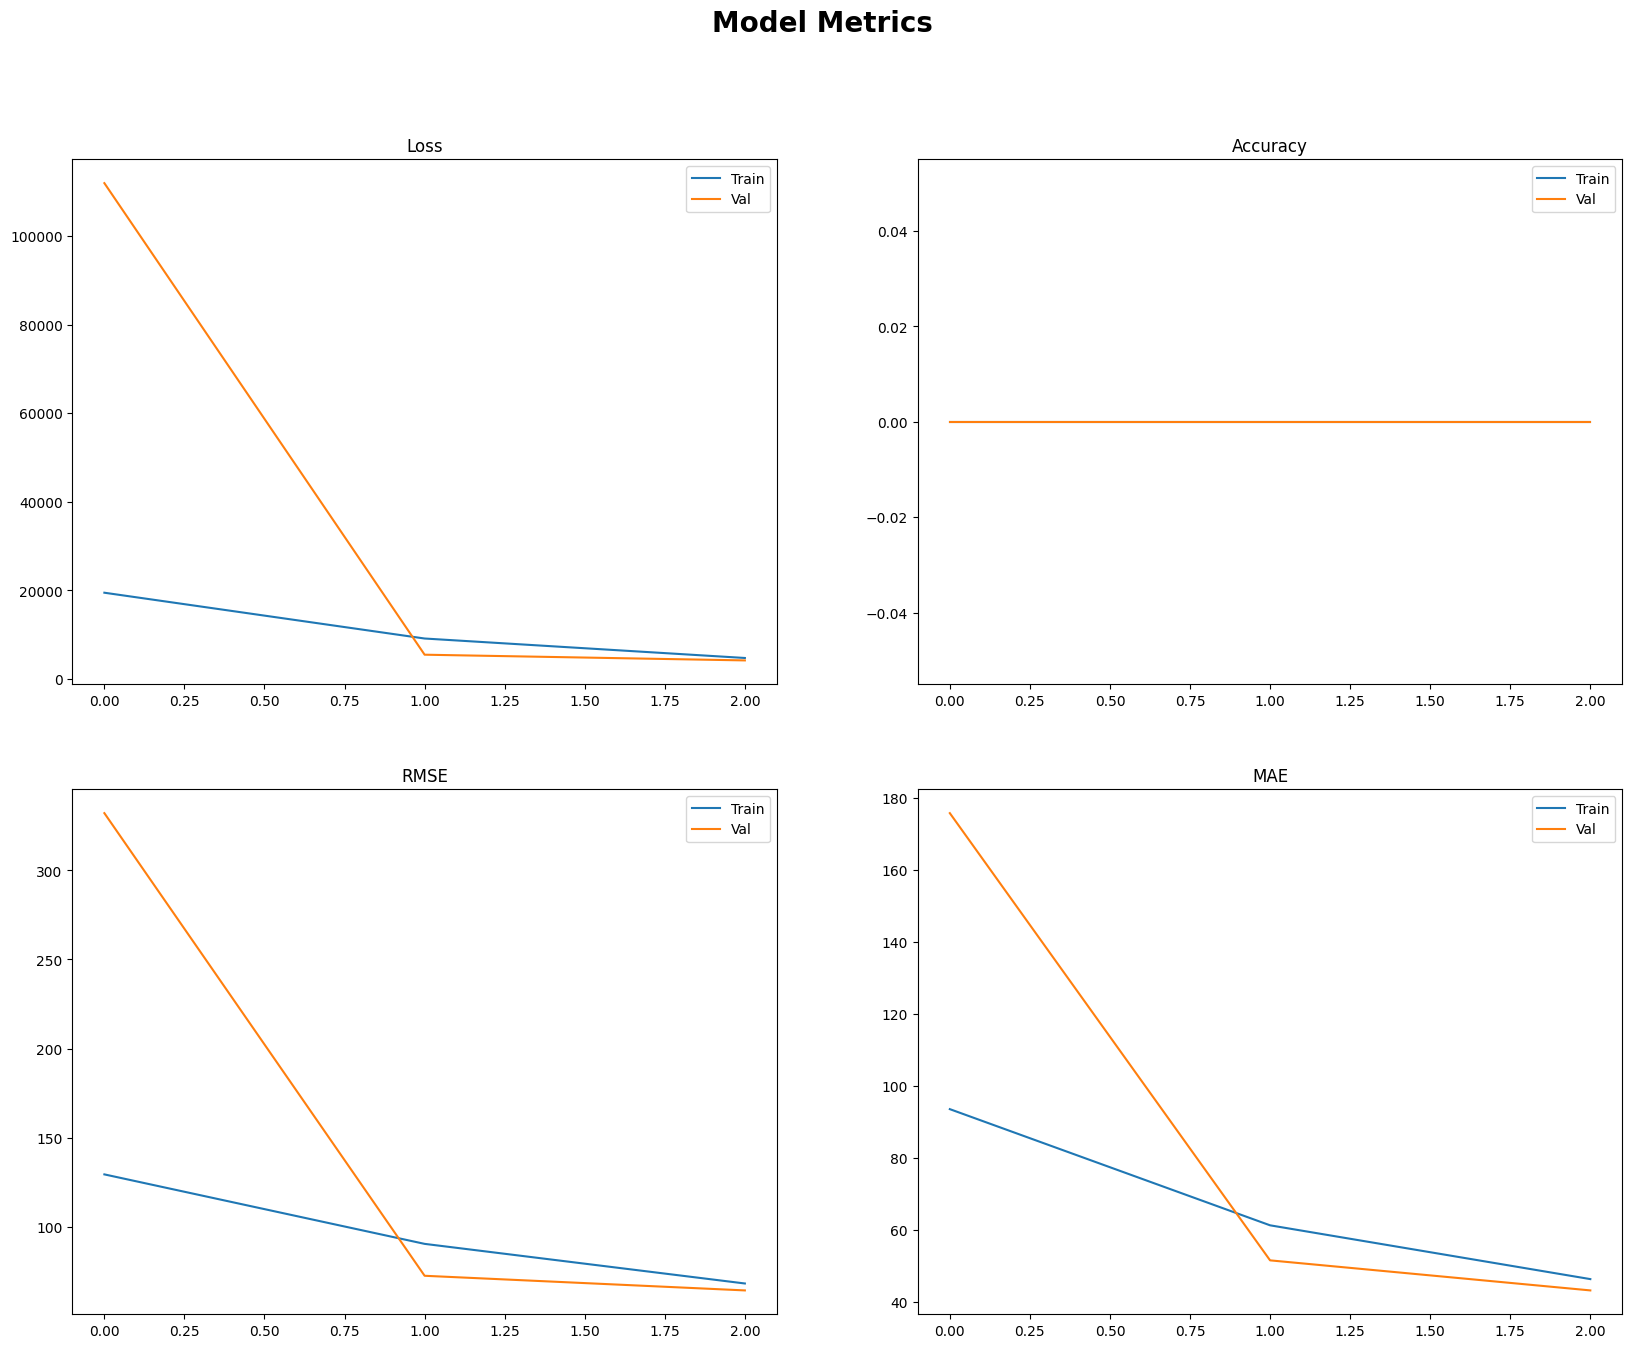

In [24]:
torch.cuda.empty_cache()

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

satellite_encoder = BaseEncoder(arch=SATELLITE_ENCODER, no_channels=7, dropout=DROPOUT, add_block=SATELLITE_EXTRA_LAYER, num_frozen=NUM_FROZEN_LAYERS)
street_encoder = BaseEncoder(arch=STREET_ENCODER, no_channels=3, dropout=DROPOUT, add_block=STREET_EXTRA_LAYER, num_frozen=NUM_FROZEN_LAYERS)

model = AQIPrediction(satellite_encoder, street_encoder, dropout=DROPOUT, num_classes=None)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(train_loader), epochs=EPOCHS)

history = train(model, optimizer, scheduler, train_loader, val_loader, test_loader, device, EPOCHS, f'{RUN_NAME}_best_model.pth')

plot_metrics(**history)